In [1]:
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import sys
import pytz
import math
from math import pow
from math import radians
import astropy.time
import astropy.coordinates
import lumos.calculator
import lumos.conversions
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import pytz
import math
from math import radians
import pandas as pd
from pyorbital.orbital import Orbital


sys.path.append('/Users/physarah/Development/satellite-optical-brightness/analysis')


import satellite_models.diffuse_sphere as diffuse_sphere
import satellite_models.starlink_v1p5 as starlink_v1p5
import satellite_models.starlink_v1p0 as starlink_v1p0
import satellite_models.starlink_v2p0 as starlink_v2p0


%matplotlib inline

satellite_data = pd.read_csv('/Users/physarah/Desktop/extra_data_with_versions_with_tle.csv')

In [2]:
len(satellite_data['norad_id'].unique())

46

In [3]:
satellite_data.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0',
       'source_mean', 'source_median', 'source_sum', 'source_rate', 'sky_mean',
       'sky_median', 'sky_sum', 'sky_rate', 'target_mean', 'target_median',
       'target_sum', 'target_rate', 'sc_area', 'bk_area', 'exposure_time',
       'datetimes_sat', 'gains_sat', 'airmass', 'm_inst', 'm_inst_sky',
       'calibed_mags', 'altitude', 'azimuth', 'utc', 'zenith_angle',
       'km_distance', 'sunsep', 'sat_name', 'norad_id', 'v_type',
       'tle_filename', 'tle1', 'tle2', 'tle3'],
      dtype='object')

In [4]:
ts = load.timescale()

altitudes_line = []
azimuths_line = []
distance_list_line = []
times = []
altitudes = []
longitude = []
latitude = []

for index, row_data in satellite_data.iterrows():

    orb_sat = Orbital(satellite=row_data['tle1'], line1=row_data['tle2'], line2=row_data['tle3'])

    satellite = EarthSatellite(row_data['tle2'], row_data['tle3'], name=row_data['tle1'])        
    observer_location = Topos('33.7703 S', '151.1112 E', elevation_m=70) # Macquarie Observatory
    TIME_PD = pd.to_datetime(row_data['datetimes_sat']).replace(tzinfo=pytz.utc)
    time_sf = ts.utc(TIME_PD)

    topocentric = (satellite - observer_location).at(time_sf)
    satellite_position = satellite.at(time_sf)
    earth_radius_km = 6371.0  

    observer_latitude = radians(-33.7703)  
    observer_longitude = radians(151.1112)  
    
    delta_longitude = satellite_position.subpoint().longitude.radians - observer_longitude
    delta_latitude = satellite_position.subpoint().latitude.radians - observer_latitude

    a = (pow(math.sin(delta_latitude / 2), 2) +
         math.cos(observer_latitude) * math.cos(satellite_position.subpoint().latitude.radians) *
         pow(math.sin(delta_longitude / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance_km = earth_radius_km * c
    distance_list_line.append(distance_km)

    lon, lat, height = orb_sat.get_lonlatalt(pd.to_datetime(row_data['datetimes_sat']))
    longitude.append(lon)
    latitude.append(lat)
    altitudes.append(height)
    alt, az, _ = topocentric.altaz()
    altitudes_line.append(alt.degrees)
    azimuths_line.append(az.degrees)
    times.append(time_sf.utc_datetime())

In [5]:
satellite_data['altitude2'] = altitudes_line
satellite_data['azimuth2'] = azimuths_line
satellite_data['forest_time'] = times
satellite_data['line_distance'] = distance_list_line
satellite_data['sat_height'] = np.array(altitudes)*1000
satellite_data['longitude'] = longitude
satellite_data['latitude'] = latitude

In [6]:
mount_lemmon = astropy.coordinates.EarthLocation(lat = -33.7703, lon = 151.1112)

In [7]:
import lumos.constants as cst
cst.SUN_INTENSITY

1233

In [8]:
lumos.constants.WAVELENGTH

5.32e-07

In [9]:
satellite_data_v1 = satellite_data[satellite_data['v_type']=='V1.0']
satellite_data_v15 = satellite_data[satellite_data['v_type']=='V1.5']
satellite_data_v2 = satellite_data[satellite_data['v_type']=='V2.0 mini']

In [15]:
intensities_lab_brdfs_V1 = []

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data_v1['altitude2'], satellite_data_v1['azimuth2'], 
                  satellite_data_v1['sat_height'], satellite_data_v1['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs_V1.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p0.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=150,
            earth_brdf=lumos.brdf.library.LAMBERTIAN(0.14))) # use the vegitation example that Forrest uses 

satellite_data_v1['sun_alt'] = sun_alt_list
satellite_data_v1['sun_az'] = sun_az_list

float_list = np.array([float(arr) for arr in intensities_lab_brdfs_V1])
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(float_list)
satellite_data_v1['forrest_mags'] = magnitudes_lab_brdfs

/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/2296018929.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satellite_data_v1['sun_alt'] = sun_alt_list
/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/2296018929.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satellite_data_v1['sun_az'] = sun_az_list
/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/2296018929.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [16]:
intensities_lab_brdfs_V15 = []

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data_v15['altitude2'], satellite_data_v15['azimuth2'],
                  satellite_data_v15['sat_height'], satellite_data_v15['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs_V15.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=150,
            earth_brdf=lumos.brdf.library.LAMBERTIAN(0.14))) # use the vegitation example that Forrest uses 

satellite_data_v15['sun_alt'] = sun_alt_list
satellite_data_v15['sun_az'] = sun_az_list

float_list = np.array([float(arr) for arr in intensities_lab_brdfs_V15])
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(float_list)
satellite_data_v15['forrest_mags'] = magnitudes_lab_brdfs

/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/38090009.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satellite_data_v15['sun_alt'] = sun_alt_list
/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/38090009.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satellite_data_v15['sun_az'] = sun_az_list
/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/38090009.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [17]:
intensities_lab_brdfs_V2 = []

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data_v2['altitude2'], satellite_data_v2['azimuth2'],
                  satellite_data_v2['sat_height'], satellite_data_v2['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs_V2.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v2p0.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=150,
            earth_brdf=lumos.brdf.library.LAMBERTIAN(0.14))) # use the vegitation example that Forrest uses 

satellite_data_v2['sun_alt'] = sun_alt_list
satellite_data_v2['sun_az'] = sun_az_list

float_list = np.array([float(arr) for arr in intensities_lab_brdfs_V2])
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(float_list)
satellite_data_v2['forrest_mags'] = magnitudes_lab_brdfs

/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/3555165480.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satellite_data_v2['sun_alt'] = sun_alt_list
/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/3555165480.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satellite_data_v2['sun_az'] = sun_az_list
/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/3555165480.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [18]:
new_mags_dataframe = pd.concat([satellite_data_v1, satellite_data_v15, satellite_data_v2])

In [19]:

satellite_data_v1 = new_mags_dataframe[new_mags_dataframe['v_type']=='V1.0']
satellite_data_v15 = new_mags_dataframe[new_mags_dataframe['v_type']=='V1.5']
satellite_data_v2 = new_mags_dataframe[new_mags_dataframe['v_type']=='V2.0 mini']

intensities_lab_brdfs_V2 = []
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data_v2['altitude2'], satellite_data_v2['azimuth2'],
                  satellite_data_v2['sat_height'], satellite_data_v2['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs_V2.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v2p0.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=150,
            earth_brdf=lumos.brdf.library.LAMBERTIAN(0.9))) # use the vegitation example that Forrest uses 

float_list = np.array([float(arr) for arr in intensities_lab_brdfs_V2])
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(float_list)
satellite_data_v2['forrest_mags_no_earth'] = magnitudes_lab_brdfs

intensities_lab_brdfs_V1 = []
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data_v1['altitude2'], satellite_data_v1['azimuth2'],
                  satellite_data_v1['sat_height'], satellite_data_v1['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs_V1.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p0.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=150,
            earth_brdf=lumos.brdf.library.LAMBERTIAN(0.9))) # use the vegitation example that Forrest uses 

float_list = np.array([float(arr) for arr in intensities_lab_brdfs_V1])
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(float_list)
satellite_data_v1['forrest_mags_no_earth'] = magnitudes_lab_brdfs

intensities_lab_brdfs_V15 = []
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data_v15['altitude2'], satellite_data_v15['azimuth2'],
                  satellite_data_v15['sat_height'], satellite_data_v15['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs_V15.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=150,
            earth_brdf=lumos.brdf.library.LAMBERTIAN(0.9))) # use the vegitation example that Forrest uses 

float_list = np.array([float(arr) for arr in intensities_lab_brdfs_V15])
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(float_list)
satellite_data_v15['forrest_mags_no_earth'] = magnitudes_lab_brdfs

/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/1970006198.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satellite_data_v2['forrest_mags_no_earth'] = magnitudes_lab_brdfs
/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/1970006198.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satellite_data_v1['forrest_mags_no_earth'] = magnitudes_lab_brdfs
/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_62365/1970006198.py:69: SettingWithCopyWarning: 
A value is try

In [20]:
new_mags_dataframe = pd.concat([satellite_data_v1, satellite_data_v15, satellite_data_v2])

(array([111.,  18.,  35.,  42.,  48.,  44.,  21.,  13.,  10.,  13.]),
 array([-0.63818126, -0.59051019, -0.54283911, -0.49516803, -0.44749695,
        -0.39982588, -0.3521548 , -0.30448372, -0.25681265, -0.20914157,
        -0.16147049]),
 <BarContainer object of 10 artists>)

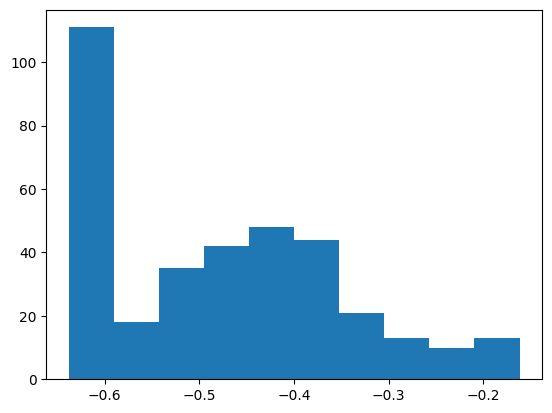

In [27]:
new_mags_dataframe_high = new_mags_dataframe[new_mags_dataframe['altitude']>60]

plt.hist(new_mags_dataframe_high['forrest_mags_no_earth']-new_mags_dataframe_high['forrest_mags'])

(0.0, 1.0)

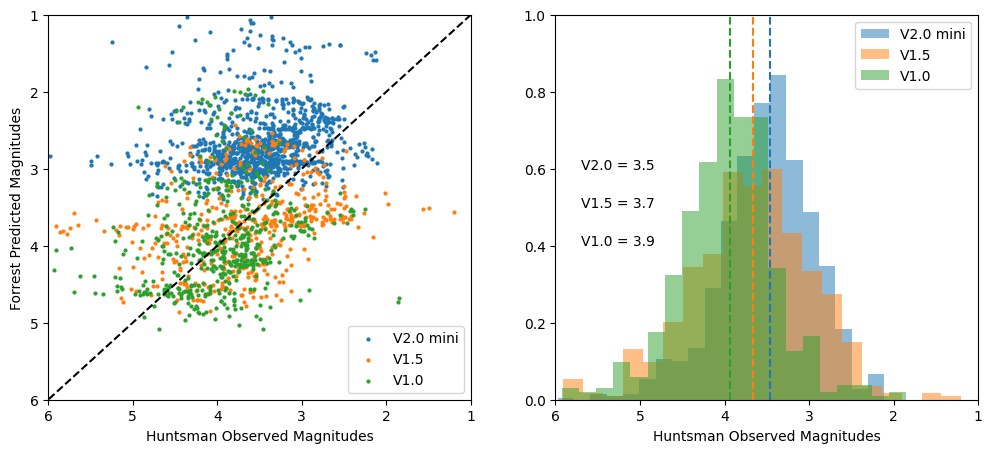

In [36]:
satellite_data_v1 = new_mags_dataframe[new_mags_dataframe['v_type']=='V1.0']
satellite_data_v15 = new_mags_dataframe[new_mags_dataframe['v_type']=='V1.5']
satellite_data_v2 = new_mags_dataframe[new_mags_dataframe['v_type']=='V2.0 mini']

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y = satellite_data_v2['forrest_mags'], 
            x = satellite_data_v2['calibed_mags'], s = 4, label = 'V2.0 mini')
plt.scatter(y = satellite_data_v15['forrest_mags'], 
            x = satellite_data_v15['calibed_mags'], s = 4, label = 'V1.5')
plt.scatter(y = satellite_data_v1['forrest_mags'], 
            x = satellite_data_v1['calibed_mags'], s = 4, label = 'V1.0')
plt.legend()
plt.plot(np.linspace(1,6,100),np.linspace(1,6,100), c = 'black', ls = '--')
plt.ylim(6,1)
plt.xlim(6,1)

plt.ylabel("Forrest Predicted Magnitudes")
plt.xlabel("Huntsman Observed Magnitudes")


plt.subplot(1,2,2)
plt.hist(satellite_data_v2['calibed_mags'], density = True, label = 'V2.0 mini', alpha = 0.5, bins = 20)
plt.hist(satellite_data_v15['calibed_mags'], density = True, label = 'V1.5', alpha = 0.5, bins = 20)
plt.hist(satellite_data_v1['calibed_mags'], density = True, label = 'V1.0', alpha = 0.5, bins = 20)
plt.axvline(np.median(satellite_data_v2['calibed_mags']), color = 'C0', ls = '--')
plt.axvline(np.median(satellite_data_v15['calibed_mags']), color = 'C1', ls = '--')
plt.axvline(np.median(satellite_data_v1['calibed_mags']), color = 'C2', ls = '--')
plt.xlabel("Huntsman Observed Magnitudes")

plt.text(5.7, 0.6, f"V2.0 = {round(np.median(satellite_data_v2['calibed_mags']),1)}")
plt.text(5.7, 0.5, f"V1.5 = {round(np.median(satellite_data_v15['calibed_mags']),1)}")
plt.text(5.7, 0.4, f"V1.0 = {round(np.median(satellite_data_v1['calibed_mags']),1)}")

plt.legend()
plt.xlim(6,1)
plt.ylim(0,1)


In [145]:
bin_subset = new_mags_dataframe[['datetimes_sat','calibed_mags','forrest_mags','altitude2','sun_sep','sun_a]]

In [146]:
bin_subset.loc[:, 'dts'] = pd.to_datetime(bin_subset['datetimes_sat'])

/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_61130/3583114453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_subset.loc[:, 'dts'] = pd.to_datetime(bin_subset['datetimes_sat'])


In [147]:
bin_subset['rounded_timestamp'] = bin_subset['dts'].dt.round('3s')

/var/folders/8p/5731jz1n2rb34n99zjc89td80000gn/T/ipykernel_61130/3182667922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_subset['rounded_timestamp'] = bin_subset['dts'].dt.round('3s')


In [148]:
bin_subset = bin_subset.drop(['datetimes_sat','dts'], axis = 1)
result = bin_subset.groupby('rounded_timestamp').mean()

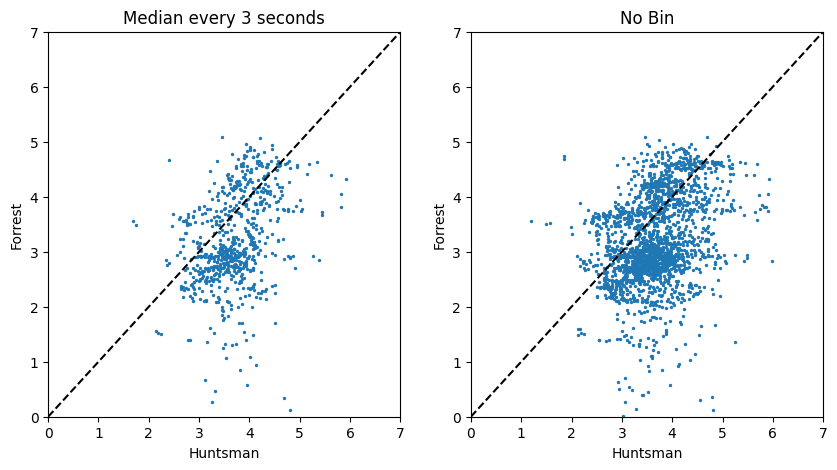

In [149]:
plt.figure(figsize = (10,5))


plt.subplot(1,2,1)

plt.scatter(x=result['calibed_mags'], y=result['forrest_mags'], s = 2)
plt.plot(np.linspace(0,7),np.linspace(0,7), ls = '--', color = 'black')
plt.ylim(0,7)
plt.xlim(0,7)
plt.xlabel("Huntsman")
plt.ylabel("Forrest")
plt.title("Median every 3 seconds")

plt.subplot(1,2,2)

plt.scatter(x=new_mags_dataframe['calibed_mags'], y=new_mags_dataframe['forrest_mags'], s = 2)
plt.plot(np.linspace(0,7),np.linspace(0,7), ls = '--', color = 'black')
plt.ylim(0,7)
plt.xlim(0,7)
plt.title("No Bin")
plt.xlabel("Huntsman")
plt.ylabel("Forrest")

plt.savefig('/Users/physarah/Desktop/test_binning.png')

(array([0.00820902, 0.03078382, 0.2832111 , 0.38787607, 0.50075006,
        0.1436578 , 0.05951538, 0.01436578, 0.00410451, 0.00820902]),
 array([-2.26269021, -1.56857478, -0.87445934, -0.1803439 ,  0.51377154,
         1.20788697,  1.90200241,  2.59611785,  3.29023329,  3.98434872,
         4.67846416]),
 <BarContainer object of 10 artists>)

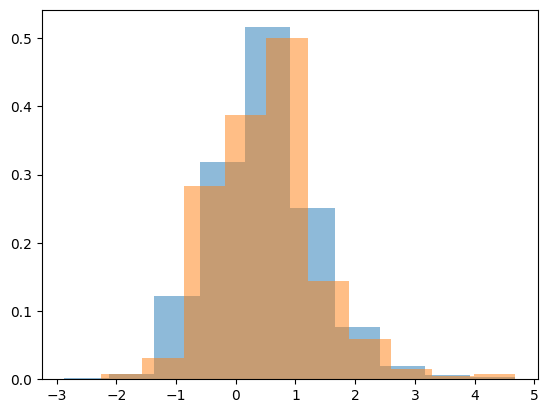

In [150]:
plt.hist(new_mags_dataframe['calibed_mags']-new_mags_dataframe['forrest_mags'], density = True, alpha = 0.5)
plt.hist(result['calibed_mags']-result['forrest_mags'], density = True, alpha = 0.5)

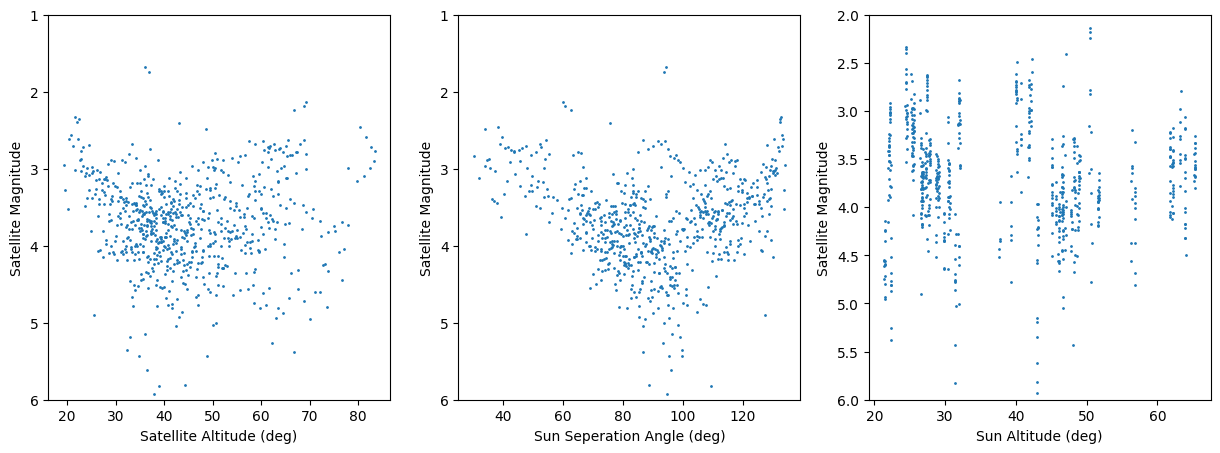

In [162]:
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)

plt.scatter(result['altitude2'],result['calibed_mags'], s = 1)
plt.ylim(6,2)
plt.ylim(6,1)
plt.xlabel("Satellite Altitude (deg)")
plt.ylabel("Satellite Magnitude")
plt.subplot(1,3,2)
plt.scatter(result['sunsep'],result['calibed_mags'], s = 1)
plt.ylim(6,2)
plt.ylim(6,1)
plt.xlabel("Sun Seperation Angle (deg)")
plt.ylabel("Satellite Magnitude")

plt.subplot(1,3,3)
plt.scatter(result['sun_alt'],result['calibed_mags'], s = 1)
plt.ylim(6,2)
plt.xlabel("Sun Altitude (deg)")
plt.ylabel("Satellite Magnitude")
plt.savefig('/Users/physarah/Desktop/scatter_tests_binned.png')